In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('heart.csv')
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [3]:
categorical_val = []
continuous_val = []
for col in df.columns:
    if len(df[col].unique()) <= 10:
        categorical_val.append(col)
    else:
        continuous_val.append(col)

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

categorical_val.remove('target')

#transformation pipeline
transform_pipe = ColumnTransformer([
    ("continuous", StandardScaler(), continuous_val),
    ("categorical", OneHotEncoder(), categorical_val)#dummy elemets
])

In [6]:
#preprocessing
X_train = transform_pipe.fit_transform(X_train)
X_test = transform_pipe.transform(X_test)
X_train[:2]

array([[-1.67339636, -2.14786993, -0.88680513,  1.27119034, -0.93118976,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-2.76362385, -0.02777897, -0.79502487,  2.2844851 , -0.93118976,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ]])

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, x_train, y_train, x_test, y_test, train, print_clf_report=False, print_cf_matrix=False):
    if train == True:
        pred = clf.predict(x_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print(f'Accuracy Score: {accuracy_score(y_train, pred) * 100:.4f}%')
        if print_clf_report:
            print('______________________________________________________________________')
            print(f'Classification Report:\n{clf_report}')
        if print_cf_matrix:
            print('______________________________________________________________________')
            print(f'Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n')
    elif train == False:
        pred = clf.predict(x_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print(f'Accuracy Score: {accuracy_score(y_test, pred) * 100:.4f}%')
        if print_clf_report:
            print('______________________________________________________________________')
            print(f'Classification Report:\n{clf_report}')
        if print_cf_matrix:
            print('______________________________________________________________________')
            print(f'Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n')

### 1. Logistic regression

#### 1.1. Without hyperparameter tuning

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [9]:
print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 86.7925%


In [10]:
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 85.7143%


#### 1.2. Using hyperparameter tuning

In [11]:
from sklearn.model_selection import GridSearchCV

params_lr = {'C': np.logspace(-4, 5, 20), 'solver': ['liblinear'], 'penalty':['l1','l2']}
lr_cv = GridSearchCV(LogisticRegression(), params_lr, scoring='accuracy', n_jobs=1, verbose=1, cv=5)
lr_cv.fit(X_train, y_train)
lr_cv.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


{'C': 0.2069138081114788, 'penalty': 'l1', 'solver': 'liblinear'}

In [12]:
print_score(lr_cv, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 85.8491%


In [13]:
print_score(lr_cv, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 85.7143%


In [14]:
lr_clf_train = accuracy_score(y_train, lr_clf.predict(X_train)) * 100
lr_clf_test = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
lr_clf_tuning_train = accuracy_score(y_train, lr_cv.predict(X_train)) * 100
lr_clf_tuning_test = accuracy_score(y_test, lr_cv.predict(X_test)) * 100

result = pd.DataFrame(columns=['Model', 'Non-tuning train accuracy %', 'Tuning train accuracy %', 'Non-tuning test accuracy %', 'Tuning test accuracy %'])
lr_result = pd.DataFrame(data=[['Logistic regression', lr_clf_train, lr_clf_tuning_train, lr_clf_test, lr_clf_tuning_test]],
                        columns=['Model', 'Non-tuning train accuracy %', 'Tuning train accuracy %', 'Non-tuning test accuracy %', 'Tuning test accuracy %'])
result = result.append(lr_result, ignore_index=True)
result

Model  Non-tuning train accuracy %  Tuning train accuracy %  \
0  Logistic regression                    86.792453                85.849057   

   Non-tuning test accuracy %  Tuning test accuracy %  
0                   85.714286               85.714286

### 2. $k$-Nearest Neighbors

#### 2.1. Without hyperparameter tuning

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier().fit(X_train, y_train)

In [16]:
print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 87.2642%


In [17]:
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 85.7143%


#### 2.2. Using hyperparameter tuning

In [18]:
from sklearn.model_selection import cross_val_score
train_score = []
#test_score = []
neighbors = range(1, 30)

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    cv_score = cross_val_score(model, X_train, y_train, cv=5).mean()
    train_score.append(cv_score)
#     test_score.append(accuracy_score(y_test, model.predict(x_test)))

Maximum KNN score on the test data: 83.95% at k=8.


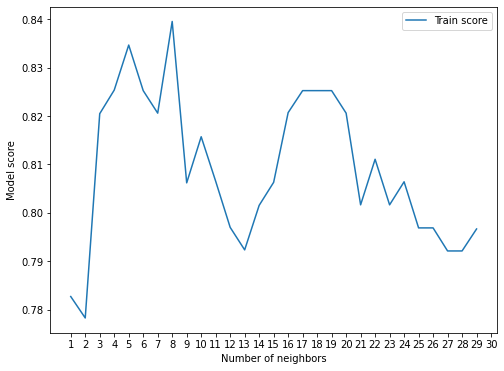

In [19]:
plt.figure(figsize=(8,6))

plt.plot(neighbors, train_score, label="Train score")
# plt.plot(neighbors, test_score, label="Test score")
plt.xticks(np.arange(1, 31, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(train_score)*100:.2f}% at k={train_score.index(max(train_score))+1}.")

In [20]:
knn_clf_tuning = KNeighborsClassifier(n_neighbors=8).fit(X_train, y_train)

In [21]:
print_score(knn_clf_tuning, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 85.3774%


In [22]:
print_score(knn_clf_tuning, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 85.7143%


In [23]:
knn_clf_test = accuracy_score(y_test, knn_clf.predict(X_test)) * 100
knn_clf_train = accuracy_score(y_train, knn_clf.predict(X_train)) * 100
knn_clf_tuning_test = accuracy_score(y_test, knn_clf_tuning.predict(X_test)) * 100
knn_clf_tuning_train = accuracy_score(y_train, knn_clf_tuning.predict(X_train)) * 100

knn_result = pd.DataFrame(data=[['K-nearest neighbors', knn_clf_train, knn_clf_tuning_train, knn_clf_test, knn_clf_tuning_test]],
                        columns=['Model', 'Non-tuning train accuracy %', 'Tuning train accuracy %', 'Non-tuning test accuracy %', 'Tuning test accuracy %'])
result = result.append(knn_result, ignore_index=True)
result

Model  Non-tuning train accuracy %  Tuning train accuracy %  \
0  Logistic regression                    86.792453                85.849057   
1  K-nearest neighbors                    87.264151                85.377358   

   Non-tuning test accuracy %  Tuning test accuracy %  
0                   85.714286               85.714286  
1                   85.714286               85.714286

### 3. Support Vector Machine

#### 3.1 Without hyperparameter tuning

In [24]:
from sklearn.svm import SVC

svm_clf = SVC().fit(X_train, y_train)

In [25]:
print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 92.4528%


In [26]:
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 87.9121%


#### 3.2 Using hyperparameter tuning

In [27]:
params_svc = [{'C': np.logspace(-2, 2, 20), 'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': np.logspace(-3,1,12)},
              {'C': np.logspace(-4, 4, 10), 'kernel': ['linear']}]
svc_cv = GridSearchCV(SVC(random_state=42), params_svc, scoring='accuracy', n_jobs=-1, verbose=1, cv=5)
svc_cv.fit(X_train, y_train)
svc_cv.best_params_

Fitting 5 folds for each of 730 candidates, totalling 3650 fits


{'C': 37.92690190732246, 'gamma': 0.0023101297000831605, 'kernel': 'rbf'}

In [28]:
print_score(svc_cv, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 87.7358%


In [29]:
print_score(svc_cv, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 85.7143%


In [30]:
svc_train = accuracy_score(y_train, svm_clf.predict(X_train)) * 100
svc_test = accuracy_score(y_test, svm_clf.predict(X_test)) * 100
svc_tuning_train = accuracy_score(y_train, svc_cv.predict(X_train)) * 100
svc_tuning_test = accuracy_score(y_test, svc_cv.predict(X_test)) * 100

svc_result = pd.DataFrame(data=[['Support Vector Machine', svc_train, svc_tuning_train, svc_test, svc_tuning_test]],
                        columns=['Model', 'Non-tuning train accuracy %', 'Tuning train accuracy %', 'Non-tuning test accuracy %', 'Tuning test accuracy %'])
result = result.append(svc_result, ignore_index=True)
result

Model  Non-tuning train accuracy %  \
0     Logistic regression                    86.792453   
1     K-nearest neighbors                    87.264151   
2  Support Vector Machine                    92.452830   

   Tuning train accuracy %  Non-tuning test accuracy %  Tuning test accuracy %  
0                85.849057                   85.714286               85.714286  
1                85.377358                   85.714286               85.714286  
2                87.735849                   87.912088               85.714286

### 4. Decision Tree

#### 4.1 Without hyperparamter tuning

In [31]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [32]:
print_score(dt_clf, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 100.0000%


In [33]:
print_score(dt_clf, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 78.0220%


#### 4.2 Using hyperparameter tuning

In [34]:
params = {'criterion': ('gini', 'entropy'), 
          'splitter': ('best', 'random'), 
          'max_depth': (list(range(1, 20))), 
          'min_samples_split': [2, 3, 4], 
          'min_samples_leaf': list(range(1, 20))
          }
dt_cv = GridSearchCV(dt_clf, params, scoring='accuracy', n_jobs=-1, verbose=1, cv=3).fit(X_train, y_train)
best_params = dt_cv.best_params_
print(f'Best_params: {best_params}')

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best_params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}


In [35]:
print_score(dt_cv, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 91.9811%


In [36]:
print_score(dt_cv, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 81.3187%


In [37]:
dt_clf_train = accuracy_score(y_train, dt_clf.predict(X_train)) * 100
dt_clf_test = accuracy_score(y_test, dt_clf.predict(X_test)) * 100
dt_cv_tuning_train = accuracy_score(y_train, dt_cv.predict(X_train)) * 100
dt_cv_tuning_test = accuracy_score(y_test, dt_cv.predict(X_test)) * 100

dt_clf_result = pd.DataFrame(data=[['Decision Tree', dt_clf_train, dt_cv_tuning_train, dt_clf_test, dt_cv_tuning_test]],
                        columns=['Model', 'Non-tuning train accuracy %', 'Tuning train accuracy %', 'Non-tuning test accuracy %', 'Tuning test accuracy %'])
result = result.append(dt_clf_result, ignore_index=True)
result

Model  Non-tuning train accuracy %  \
0     Logistic regression                    86.792453   
1     K-nearest neighbors                    87.264151   
2  Support Vector Machine                    92.452830   
3           Decision Tree                   100.000000   

   Tuning train accuracy %  Non-tuning test accuracy %  Tuning test accuracy %  
0                85.849057                   85.714286               85.714286  
1                85.377358                   85.714286               85.714286  
2                87.735849                   87.912088               85.714286  
3                91.981132                   78.021978               81.318681

### 5. Random Forest

#### 5.1 Without hyperparameter tuning

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42).fit(X_train, y_train)

In [39]:
print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 100.0000%


In [40]:
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 82.4176%


#### 5.2 Using hyperparameter tuning

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
params_rf = [{'bootstrap':[True], 'max_depth': sp_randint(2,50),'min_samples_leaf': sp_randint(1,30), 'min_samples_split': sp_randint(2,30), 'max_samples':sp_randint(10,200)},
             {'bootstrap':[False], 'max_depth': sp_randint(2,50),'min_samples_leaf': sp_randint(1,30), 'min_samples_split': sp_randint(2,30)}
             ]
rf_cv = RandomizedSearchCV(RandomForestClassifier(), params_rf, scoring='accuracy', n_jobs=-1, verbose=1, cv=5, n_iter=50)
rf_cv.fit(X_train, y_train)
rf_cv.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'bootstrap': False,
 'max_depth': 31,
 'min_samples_leaf': 18,
 'min_samples_split': 25}

In [42]:
print_score(rf_cv, X_train, y_train, X_test, y_test, train=True)

Accuracy Score: 88.2075%


In [43]:
print_score(rf_cv, X_train, y_train, X_test, y_test, train=False)

Accuracy Score: 82.4176%


In [44]:
rf_clf_train = accuracy_score(y_train, rf_clf.predict(X_train)) * 100
rf_clf_test = accuracy_score(y_test, rf_clf.predict(X_test)) * 100
rf_cv_tuning_train = accuracy_score(y_train, rf_cv.predict(X_train)) * 100
rf_cv_tuning_test = accuracy_score(y_test, rf_cv.predict(X_test)) * 100

rf_clf_result = pd.DataFrame(data=[['Random Forest', rf_clf_train, rf_cv_tuning_train, rf_clf_test, rf_cv_tuning_test]],
                        columns=['Model', 'Non-tuning train accuracy %', 'Tuning train accuracy %', 'Non-tuning test accuracy %', 'Tuning test accuracy %'])
result = result.append(rf_clf_result, ignore_index=True)
result

Model  Non-tuning train accuracy %  \
0     Logistic regression                    86.792453   
1     K-nearest neighbors                    87.264151   
2  Support Vector Machine                    92.452830   
3           Decision Tree                   100.000000   
4           Random Forest                   100.000000   

   Tuning train accuracy %  Non-tuning test accuracy %  Tuning test accuracy %  
0                85.849057                   85.714286               85.714286  
1                85.377358                   85.714286               85.714286  
2                87.735849                   87.912088               85.714286  
3                91.981132                   78.021978               81.318681  
4                88.207547                   82.417582               82.417582